In [1]:
import torch 
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import seaborn as sns

In [3]:
from torch.utils.data import TensorDataset, DataLoader

In [4]:
from sklearn.metrics import classification_report

In [5]:
path_to_train='Train/'
path_to_valid = 'Valid/'
path_to_test='Test/'

In [6]:
X_train=np.load(path_to_train+"X_train.npy")
X_valid=np.load(path_to_valid+"X_valid.npy")

In [7]:
y_train_superclass=np.load(path_to_train+"y_train_subclass.npy")
y_valid_superclass=np.load(path_to_valid+"y_valid_subclass.npy")

In [8]:
batch_size = 128

In [9]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.LongTensor(y_train_superclass)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

X_valid_tensor = torch.Tensor(X_valid)
y_valid_tensor = torch.LongTensor(y_valid_superclass)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = True)

In [10]:
X_test=np.load(path_to_test+"X_test.npy")
y_test=np.load(path_to_test+"y_test_subclass.npy")

In [11]:
del X_train
del X_valid

del y_train_superclass
del y_valid_superclass

del X_train_tensor
del y_train_tensor

del X_valid_tensor
del y_valid_tensor

In [12]:
def train(epoch,my_model, data_loader, optimizer, loss_function):
    losses=[]
    my_model.train()
    for batch_idx, (X_batch, y_batch) in enumerate(data_loader):
        optimizer.zero_grad()
        output = my_model(X_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X_batch), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item()))
        losses.append(loss.data.numpy())
    return np.mean(losses)

In [13]:
def test(my_model, data_loader, loss_function):
    accuracy_arr = []
    my_model.eval()
    test_loss = 0
    correct = 0
    for X_batch, y_batch in data_loader:
        output = my_model(X_batch)
        test_loss += loss_function(output, y_batch).data
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(y_batch.data.view_as(pred)).cpu().sum()

    test_loss /= len(data_loader)
    acc = correct / len(data_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    return acc,test_loss

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score

def print_confusion_matrix(model, X, y):
    model.eval()
    y_pred = model(torch.Tensor(X)).data.numpy().argmax(axis = 1)
    print(confusion_matrix(y, y_pred))
    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy = {accuracy}")
    return accuracy

In [15]:
def training(number_of_epoches, model, optimizer, loss_function, learning_rate, train_loader, valid_loader):
    loss_train=[]
    loss_valid=[]
    acc=[]
    best_accuracy, last_accuracy = 0, 0
    patience = 3
    trigger_times = 0 
    
    for epoch in range(number_of_epoches):
        loss_train.append(train(epoch + 1,model, train_loader, optimizer, loss_function))
        accuracy, current_loss = test(model, valid_loader, loss_function)
        acc.append(accuracy)
        loss_valid.append(current_loss)
        if accuracy < last_accuracy:
            trigger_times += 1
            if trigger_times > patience:
                break
        else:
            trigger_times = 0  
        if epoch ==int(number_of_epoches * 0.3):
            optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)    
        print("Trigger times", trigger_times) 
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
        last_accuracy = accuracy
        
    return loss_train, loss_valid, acc

In [16]:
loss_function=nn.CrossEntropyLoss()

In [17]:
learning_rate = 0.001
learning_rate_2 = 0.0001

In [18]:
input_shape=1000

In [19]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1):
        super().__init__()

        self.model = nn.Sequential(
        nn.Conv1d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size[0], padding = kernel_size[0] //2, stride = stride),
        nn.BatchNorm1d(out_channels),  nn.LeakyReLU(0.01),
        nn.Conv1d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size[1], padding = kernel_size[1] // 2),
            
        )
        self.leakyReLU = nn.LeakyReLU(0.01)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size = 1, stride = stride)
            )
        self.bn = nn.BatchNorm1d(out_channels)

        
    def forward(self, X):
        output = self.model(X)
        output += self.shortcut(X)
        output = self.bn(output)
        output = self.leakyReLU(output)

        return output

In [20]:
class CNN_ResNet(nn.Module):
    def __init__(self,in_channels,  input_shape, n_outputs, block, kernel_size = [3,3,3,5,5]):
        super().__init__()
        self.zero = nn.ZeroPad2d(3)
        self.conv1D_1 = nn.Conv1d(in_channels = in_channels+6, out_channels = 64, kernel_size =  kernel_size[0], padding = 'same')
        self.bn_1 = nn.BatchNorm1d(64)
        self.leakyReLU_1 = nn.LeakyReLU(0.01)
        self.maxpool = nn.MaxPool1d(2)
        self.conv1D_2 = nn.Conv1d(in_channels = 64, out_channels = 64, kernel_size = kernel_size[1], padding = 'same')
        self.bn_2 = nn.BatchNorm1d(64)
        self.leakyReLU_2 = nn.LeakyReLU(0.01)
    
        self.block1 = self.make_layer(block, 64, 64, kernel_size[1:3], 2)
        self.block2 = self.make_layer(block, 64, 64, kernel_size[3:5], 2)
        self.maxpool2 = nn.MaxPool1d(2)
        


        
        self.adAvgPooling = nn.AdaptiveAvgPool1d(2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(2 * 64,n_outputs)
        self.bn = nn.BatchNorm1d(n_outputs)
        self.softmax = nn.Softmax(dim=1)

    def make_layer(self, block, in_channels, out_channels, kernel_size, stride = 1):  
        return nn.Sequential(block(in_channels, out_channels, kernel_size, stride))

    def forward(self, x):
        
        output = self.zero(x)
        output = self.conv1D_1(output)
        output = self.bn_1(output)
        output = self.leakyReLU_1(output)
        output = self.maxpool(output)
  

        output = self.block1(output)
        output = self.block2(output) 
        output = self.maxpool2(output)
        
        output = self.adAvgPooling(output)
        output = self.flatten(output)
        output = self.fc(output)
        output = self.bn(output)
        output = self.softmax(output)
        return output

In [23]:
model = CNN_ResNet(12, 1000, 20, BasicBlock, [5,5,5,5,5])

In [24]:
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [25]:
loss_train, loss_valid, accuracy = training(30, model, optimizer, loss_function, learning_rate_2, train_loader, valid_loader)

Train Epoch: 1 [0/12069 (0%)]	Loss: 2.992615
Train Epoch: 1 [1280/12069 (11%)]	Loss: 2.913328
Train Epoch: 1 [2560/12069 (21%)]	Loss: 2.862349
Train Epoch: 1 [3840/12069 (32%)]	Loss: 2.815979
Train Epoch: 1 [5120/12069 (42%)]	Loss: 2.819920
Train Epoch: 1 [6400/12069 (53%)]	Loss: 2.849264
Train Epoch: 1 [7680/12069 (63%)]	Loss: 2.800776
Train Epoch: 1 [8960/12069 (74%)]	Loss: 2.816764
Train Epoch: 1 [10240/12069 (84%)]	Loss: 2.776679
Train Epoch: 1 [11520/12069 (95%)]	Loss: 2.790630

Test set: Average loss: 2.7403, Accuracy: 1405/2587 (54.31%)

Trigger times 0
Train Epoch: 2 [0/12069 (0%)]	Loss: 2.775380
Train Epoch: 2 [1280/12069 (11%)]	Loss: 2.774647
Train Epoch: 2 [2560/12069 (21%)]	Loss: 2.736934
Train Epoch: 2 [3840/12069 (32%)]	Loss: 2.757967
Train Epoch: 2 [5120/12069 (42%)]	Loss: 2.755570
Train Epoch: 2 [6400/12069 (53%)]	Loss: 2.730783
Train Epoch: 2 [7680/12069 (63%)]	Loss: 2.724345
Train Epoch: 2 [8960/12069 (74%)]	Loss: 2.723929
Train Epoch: 2 [10240/12069 (84%)]	Loss: 2.71

Train Epoch: 15 [6400/12069 (53%)]	Loss: 2.374201
Train Epoch: 15 [7680/12069 (63%)]	Loss: 2.331211
Train Epoch: 15 [8960/12069 (74%)]	Loss: 2.421204
Train Epoch: 15 [10240/12069 (84%)]	Loss: 2.345968
Train Epoch: 15 [11520/12069 (95%)]	Loss: 2.364257

Test set: Average loss: 2.4456, Accuracy: 1852/2587 (71.59%)

Trigger times 0
Train Epoch: 16 [0/12069 (0%)]	Loss: 2.430238
Train Epoch: 16 [1280/12069 (11%)]	Loss: 2.402539
Train Epoch: 16 [2560/12069 (21%)]	Loss: 2.365887
Train Epoch: 16 [3840/12069 (32%)]	Loss: 2.425196
Train Epoch: 16 [5120/12069 (42%)]	Loss: 2.359366
Train Epoch: 16 [6400/12069 (53%)]	Loss: 2.401613
Train Epoch: 16 [7680/12069 (63%)]	Loss: 2.366157
Train Epoch: 16 [8960/12069 (74%)]	Loss: 2.414671
Train Epoch: 16 [10240/12069 (84%)]	Loss: 2.407408
Train Epoch: 16 [11520/12069 (95%)]	Loss: 2.386026

Test set: Average loss: 2.4438, Accuracy: 1851/2587 (71.55%)

Trigger times 1
Train Epoch: 17 [0/12069 (0%)]	Loss: 2.365615
Train Epoch: 17 [1280/12069 (11%)]	Loss: 2.369

Train Epoch: 29 [10240/12069 (84%)]	Loss: 2.416137
Train Epoch: 29 [11520/12069 (95%)]	Loss: 2.307599

Test set: Average loss: 2.4365, Accuracy: 1861/2587 (71.94%)

Trigger times 0
Train Epoch: 30 [0/12069 (0%)]	Loss: 2.324078
Train Epoch: 30 [1280/12069 (11%)]	Loss: 2.366200
Train Epoch: 30 [2560/12069 (21%)]	Loss: 2.291230
Train Epoch: 30 [3840/12069 (32%)]	Loss: 2.386220
Train Epoch: 30 [5120/12069 (42%)]	Loss: 2.362286
Train Epoch: 30 [6400/12069 (53%)]	Loss: 2.353715
Train Epoch: 30 [7680/12069 (63%)]	Loss: 2.346774
Train Epoch: 30 [8960/12069 (74%)]	Loss: 2.337624
Train Epoch: 30 [10240/12069 (84%)]	Loss: 2.326879
Train Epoch: 30 [11520/12069 (95%)]	Loss: 2.332058

Test set: Average loss: 2.4278, Accuracy: 1843/2587 (71.24%)

Trigger times 1


In [26]:
print_confusion_matrix(model, X_test, y_test)

[[ 40   0   0   0   0   0   0   3   0   0   0   3   0   0   0   0   0   0
    7   0]
 [  0   0   0   0   0   8   4   4  18   0   7   4   0   0   1   0   0   2
    1   0]
 [  0   0   0   0   0   0   1   4   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   2   0   0   1   4   0   0
    0   0]
 [  0   0   0   0   1   4  13   2   3   0   9   2   0   0   2   0   0   2
    1   0]
 [  0   0   0   0   0  24   0   7   8   0  12   4   0   0   4   1   0   5
    4   0]
 [  0   0   0   0   0   1 934   5   8   0  70   7   0   0   7   0   0   1
   15   0]
 [  8   0   0   0   0   9  15 176  15   0   2  13   0   0  10   4   0   1
    7   0]
 [  0   0   0   0   0   2   5   5  73   0   5   5   0   0   1   1   0   3
    1   0]
 [  0   0   0   0   0   4   0   2   8   0   4   3   0   0   1   0   0   4
    0   0]
 [  0   1   0   0   0  13  39   6   9   0 168  13   0   0  11   0   0  13
    4   0]
 [  3   0   0   0   0   2   6  19   2   0  12 124   0   0   9   1

0.6925754060324826

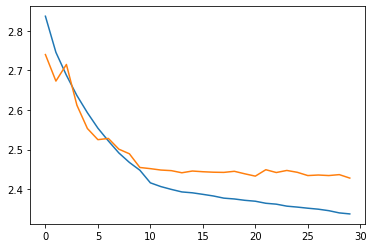

In [27]:
plt.plot(loss_train, label = 'Train Loss')
plt.plot(loss_valid, label = 'Validation Loss')
plt.show()

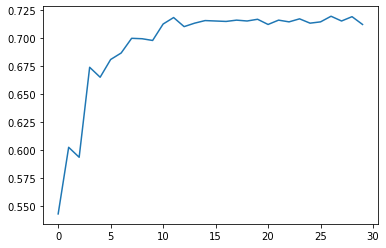

In [28]:
plt.plot(accuracy)
plt.show()

In [29]:
print("Best accuracy: ",np.max(accuracy)," Epoch: ", np.argmax(accuracy)+1)

Best accuracy:  0.7197526  Epoch:  27


In [30]:
model.eval()
y_pred = model(torch.Tensor(X_test)).data.numpy().argmax(axis = 1)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.75      0.68        53
           1       0.00      0.00      0.00        49
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         8
           4       1.00      0.03      0.05        39
           5       0.31      0.35      0.33        69
           6       0.87      0.89      0.88      1048
           7       0.69      0.68      0.68       260
           8       0.47      0.72      0.57       101
           9       0.00      0.00      0.00        26
          10       0.50      0.61      0.55       277
          11       0.61      0.66      0.63       189
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00        50
          14       0.64      0.76      0.70       142
          15       0.84      0.93      0.88        74
          16       0.00      0.00      0.00         8
          17       0.20    

D:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


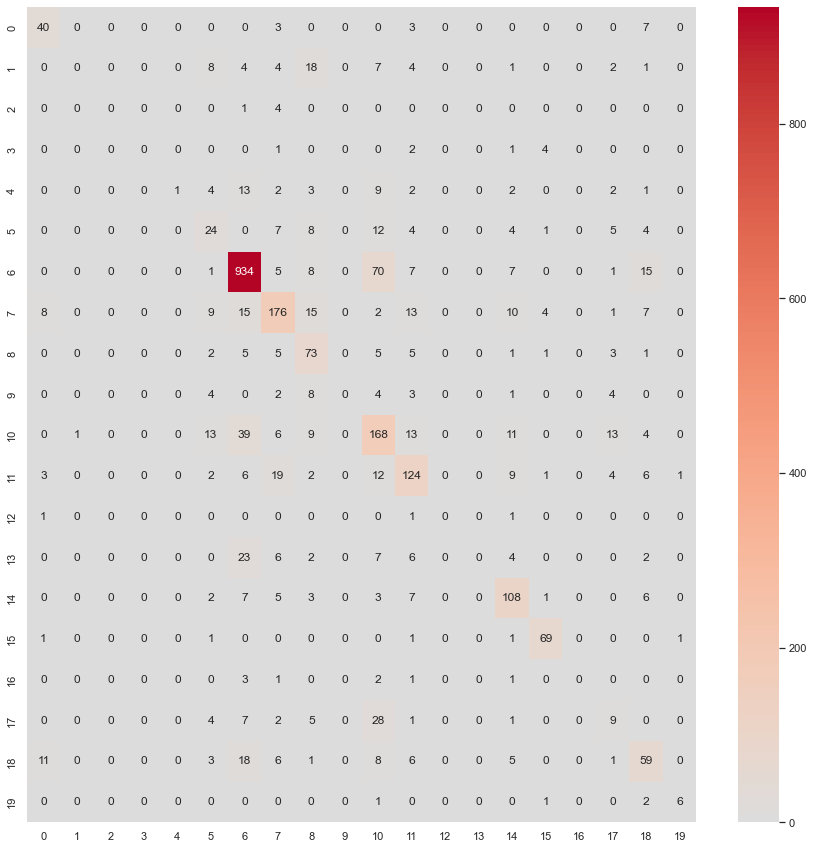

In [32]:
cm = confusion_matrix(y_test,y_pred)
sns.set(rc = {'figure.figsize':(15,15)})
f = sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', center = 0)